函數(For Anova)

In [15]:
def oneway_anova(df, response_col, factor_col):
    """
    Runs a one-way ANOVA on the given dataframe.
    
    Parameters:
    - df: pandas DataFrame containing the data
    - response_col: name of the numeric response variable
    - factor_col: name of the categorical factor

    Returns:
    - ANOVA summary table (DataFrame)
    """
    
    formula = f'{response_col} ~ C({factor_col})'
    model = smf.ols(formula, data=df).fit()
    aov_table = sms.anova_lm(model, typ=2)
    
    print("\nANOVA Table:")
    display(aov_table)
    
    return aov_table

def shapiro_wilk_test(df, response_col, factor_col, alpha=0.05):
    """
    Runs Shapiro-Wilk test for normality on each group defined by a factor column.

    Parameters:
    - df: pandas DataFrame
    - response_col: Name of the response variable
    - factor_col: Name of the factor variable
    - alpha: Significance level for the Shapiro-Wilk test

    Returns:
    - A dictionary of test results per group
    """
    results = {}
    print(f"Shapiro-Wilk Test for Normality (alpha = {alpha}):\n")

    for level in df[factor_col].unique():
        group_data = df[response_col][df[factor_col] == level]
        stat, p = stats.shapiro(group_data)
        results[level] = {'Shapiro Statistic': stat, 'p-value': p}
        
        print(f"For factor = {level}")
        print(f"  Shapiro statistic = {stat:.6f}, p-value = {p:.6f}", end=" ")
        if p > alpha:
            print("→ Likely Normal")
        else:
            print("→ Not Normal")
    
    return results

def bartlett_test(df, response_col, factor_col, alpha=0.05):
    """
    Performs Bartlett's test for equal variances across groups.

    Parameters:
    - df: pandas DataFrame
    - response_col: Name of the numeric response variable
    - factor_col: Name of the categorical factor variable
    - alpha: Significance level for the test

    Returns:
    - (statistic, p-value)
    """
    groups = df[factor_col].unique()
    data_by_group = [df[response_col][df[factor_col] == group] for group in groups]

    stat, p = stats.bartlett(*data_by_group)
    print("Bartlett’s Test for Equal Variances:")
    print(f"  Test statistic = {stat:.6f}, p-value = {p:.6f}", end=" ")

    if p > alpha:
        print("→ Equal variances assumed")
    else:
        print("→ Variances differ significantly")

    return stat, p

函數(f test, t test)

In [17]:
def f_test_variances(x1, x2, sides, alpha):
    # Convert input to NumPy arrays
    a1 = np.array(x1)
    a2 = np.array(x2)

    # Initialize results array
    result = np.full((7, 2), None, dtype=float)
    
    # Calculate basic statistics
    result[0] = [np.mean(a1), np.mean(a2)]                    # Means
    result[1] = [np.std(a1, ddof=1), np.std(a2, ddof=1)]      # Sample standard deviations
    result[2] = [a1.size, a2.size]                            # Sample sizes

    # Degrees of freedom
    dfn, dfd = a1.size - 1, a2.size - 1
    result[3] = [dfn, dfd]

    # F-statistic: ratio of sample variances
    f_stat = np.var(a1, ddof=1) / np.var(a2, ddof=1)
    result[4, 0] = f_stat

    # Critical F-values
    if sides > 1:
        result[5] = [
            stats.f.isf(alpha / 2, dfn, dfd),  # Upper critical value
            stats.f.ppf(alpha / 2, dfn, dfd)   # Lower critical value
        ]
    else:
        result[5] = [
            stats.f.isf(alpha, dfn, dfd),      # One-sided critical value
            stats.f.ppf(alpha, dfn, dfd)
        ]

    # P-value calculation
    if f_stat > 1:
        p_value = 1 - stats.f.cdf(f_stat, dfn, dfd)
    else:
        p_value = stats.f.cdf(f_stat, dfn, dfd)
    if sides > 1:
        p_value *= 2
    result[6, 0] = p_value

    # Create labeled DataFrame
    labels = ['Mean', 'Std Dev', 'Size', 'Degrees of Freedom', 'F-statistic', 'F-critical', 'p-value']
    df = pd.DataFrame(result, index=labels)

    return df

def t_test_two_means_unequal_variance(x1, x2, sides, alpha, H0_diff):
    # Convert inputs to NumPy arrays
    a1 = np.array(x1)
    a2 = np.array(x2)

    # Initialize results array
    result = np.full((8, 2), None, dtype=float)

    # Basic statistics
    mean1, mean2 = np.mean(a1), np.mean(a2)
    var1, var2 = np.var(a1, ddof=1), np.var(a2, ddof=1)
    n1, n2 = a1.size, a2.size

    result[0] = [mean1, mean2]  # Means
    result[1] = [var1, var2]    # Variances
    result[2] = [n1, n2]        # Sample sizes

    # Mean difference and its variance
    mean_diff = mean1 - mean2
    diff_var = var1 / n1 + var2 / n2

    # Hypothesized difference under H0
    result[3, 0] = H0_diff

    # Degrees of freedom (Welch-Satterthwaite equation)
    numerator = diff_var ** 2
    denominator = (var1**2 / (n1**2 * (n1 - 1))) + (var2**2 / (n2**2 * (n2 - 1)))
    df = numerator / denominator
    result[4, 0] = df

    # t-statistic
    t_stat = (mean_diff - H0_diff) / np.sqrt(diff_var)
    result[5, 0] = t_stat

    # Critical t-values
    if sides > 1:
        result[6] = [stats.t.isf(alpha / 2, df), stats.t.ppf(alpha / 2, df)]
    else:
        result[6] = [stats.t.isf(alpha, df), stats.t.ppf(alpha, df)]

    # p-value
    if t_stat > 0:
        p_value = 1 - stats.t.cdf(t_stat, df)
    else:
        p_value = stats.t.cdf(t_stat, df)
    if sides > 1:
        p_value *= 2
    result[7, 0] = p_value

    # Create labeled DataFrame
    labels = [
        'Mean', 'Variance', 'Size', 'H0 Diff',
        'Degrees of Freedom', 't-statistic', 't-critical', 'p-value'
    ]
    df = pd.DataFrame(result, index=labels)

    return df


def run_t_test_summary(df, col1, col2, usevar='pooled', alpha=0.05):
    """
    Runs a t-test using statsmodels' CompareMeans and prints a summary.

    Parameters:
    - df: DataFrame containing the columns
    - col1, col2: Column names to compare
    - usevar: 'pooled' (equal variances) or 'unequal' (Welch)
    - alpha: Significance level
    """
    group1 = sms.DescrStatsW(df[col1].values)
    group2 = sms.DescrStatsW(df[col2].values)
    t_test = sms.CompareMeans(group1, group2)
    
    return t_test.summary(usevar=usevar, alpha=alpha)



In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
# ========== 開始作檢定==========

df = pd.read_csv('movie_summary.csv')

# filter data
filtered_df = df[
    (df['production_year'] > 2000) &
    (df['production_budget'] < 20000000) &
    df['sequel'].notna() &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
].copy()
# 計算總票房
filtered_df['total_box_office'] = (
    filtered_df['domestic_box_office'] + filtered_df['international_box_office']
)

filtered_df['log_total_box_office'] = np.log1p(filtered_df['total_box_office'])

print(filtered_df['log_total_box_office'].head())

54     19.742143
65     19.940907
165    19.259875
169    19.767534
206    19.381728
Name: log_total_box_office, dtype: float64


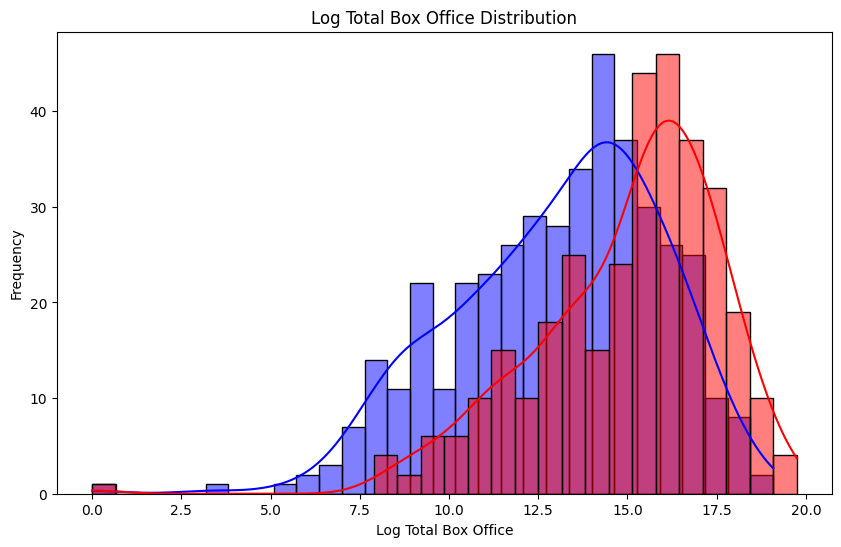

Budget Low 資料筆數：419
Budget High 資料筆數：328


In [97]:
# 新增 budget 分類
filtered_df['budget_category'] = pd.cut(filtered_df['production_budget'], bins=[10000, 2000000
, 5000000], labels=['Low', 'High'])

# 分組資料
budget_low = filtered_df[filtered_df['budget_category'] == 'Low']['log_total_box_office']
budget_high = filtered_df[filtered_df['budget_category'] == 'High']['log_total_box_office']

# Plot log_total_box_office for two groups
plt.figure(figsize=(10, 6))
sns.histplot(budget_low, bins=30, kde=True, color='blue')
sns.histplot(budget_high, bins=30, kde=True, color='red')
plt.title('Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')
plt.show()

# 寫出各個的資料筆數
print(f"Budget Low 資料筆數：{len(budget_low)}")
print(f"Budget High 資料筆數：{len(budget_high)}")


In [98]:
# 常態性檢定 (Shapiro-Wilk test)
from scipy import stats

print("常態性檢定結果 (Shapiro-Wilk test)：")
print("\nBudget Low 組：")
stat, p_value = stats.shapiro(budget_low)
print(f"樣本數：{len(budget_low)}")
print(f"統計量：{stat:.4f}")
print(f"p值：{p_value:.4f}")
print(f"結論：{'符合常態分配' if p_value > 0.05 else '不符合常態分配'}")


print("常態性檢定結果 (Shapiro-Wilk test)：")
print("\nBudget High 組：")
stat, p_value = stats.shapiro(budget_high)
print(f"樣本數：{len(budget_high)}")
print(f"統計量：{stat:.4f}")
print(f"p值：{p_value:.4f}")
print(f"結論：{'符合常態分配' if p_value > 0.05 else '不符合常態分配'}")

# 變異數同質性檢定 (Levene's test)
print("\n變異數同質性檢定 (Levene's test)：")
stat, p_value = stats.levene(budget_low, budget_high)
print(f"統計量：{stat:.4f}")
print(f"p值：{p_value:.4f}")
print(f"結論：{'變異數同質' if p_value > 0.05 else '變異數不同質'}")

# kruskal-wallis test
kruskal_result = stats.kruskal(budget_low, budget_high)
print(f"\nKruskal-Wallis 統計量：{kruskal_result.statistic:.4f}")
print(f"p值：{kruskal_result.pvalue:.4f}")
print(f"結論：{'兩組平均數無顯著差異' if kruskal_result.pvalue > 0.05 else '兩組平均數有顯著差異'}")


常態性檢定結果 (Shapiro-Wilk test)：

Budget Low 組：
樣本數：419
統計量：0.9729
p值：0.0000
結論：不符合常態分配
常態性檢定結果 (Shapiro-Wilk test)：

Budget High 組：
樣本數：328
統計量：0.9340
p值：0.0000
結論：不符合常態分配

變異數同質性檢定 (Levene's test)：
統計量：9.0680
p值：0.0027
結論：變異數不同質

Kruskal-Wallis 統計量：88.3592
p值：0.0000
結論：兩組平均數有顯著差異


In [28]:
# 執行檢定
f_result = f_test_variances(budget_low, budget_high, sides=1, alpha=0.05)
t_result = t_test_two_means_unequal_variance(budget_low, budget_high, sides=1, alpha=0.05, H0_diff=0)

print("F-Test 結果：")
print(f_result)
print("Welch T-Test 結果：")
print(t_result)


F-Test 結果：
                               0             1
Mean                5.643537e+06  1.966283e+07
Std Dev             1.594600e+07  4.077139e+07
Size                4.470000e+02  3.410000e+02
Degrees of Freedom  4.460000e+02  3.400000e+02
F-statistic         1.529651e-01           NaN
F-critical          1.183862e+00  8.465513e-01
p-value             2.386474e-72           NaN
Welch T-Test 結果：
                               0             1
Mean                5.643537e+06  1.966283e+07
Variance            2.542749e+14  1.662306e+15
Size                4.470000e+02  3.410000e+02
H0 Diff             0.000000e+00           NaN
Degrees of Freedom  4.196240e+02           NaN
t-statistic        -6.008710e+00           NaN
t-critical          1.648493e+00 -1.648493e+00
p-value             2.030657e-09           NaN



One-way ANOVA 結果：
F-statistic: 28.17560263111761
p-value: 1.5231465778613802e-12


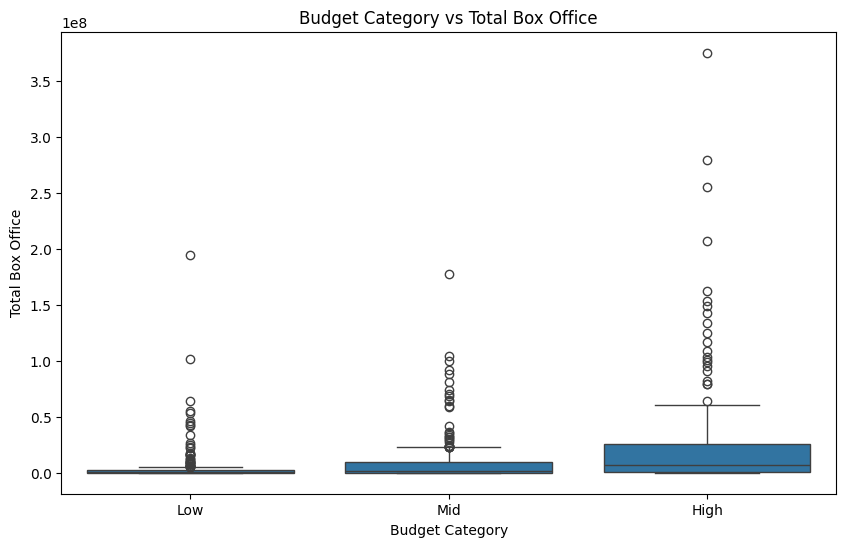

In [7]:
# One-way ANOVA
f_stat, p_value = stats.f_oneway(budget_low, budget_mid, budget_high)
print("\nOne-way ANOVA 結果：")
print(f"F-statistic: {f_stat}")
print(f"p-value: {p_value}")

# 視覺化
plt.figure(figsize=(10, 6))
sns.boxplot(x='budget_category', y='total_box_office', data=filtered_df)
plt.title('Budget Category vs Total Box Office')
plt.xlabel('Budget Category')
plt.ylabel('Total Box Office')
plt.show()